In [1]:
from itertools import islice
import numpy as np
from numpy.random import RandomState
from numpy.linalg import lstsq
from matplotlib.pyplot import plot
from ipywidgets import interact, IntSlider

In [2]:
from longstaff_schwartz.stochastic_process import GeometricBrownianMotion
from longstaff_schwartz.regression_basis import PolynomialRegressionBasis

In [3]:
rnd = RandomState(seed=1234)

In [4]:
t = np.linspace(0, 5, 12*5)
n = 50
gbm = GeometricBrownianMotion(mu=0.01, sigma=0.15)

In [5]:
X = gbm.simulate(t, n, rnd)
X.shape

(60, 50)

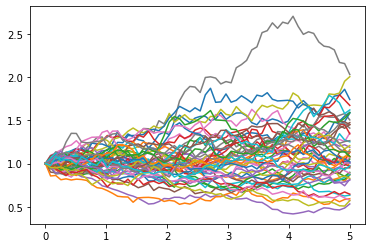

In [6]:
plot(t, X);

In [7]:
def exercise_value(s):
    return np.maximum(s - 1, 0)

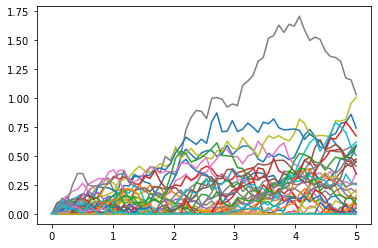

In [8]:
plot(t, exercise_value(X));

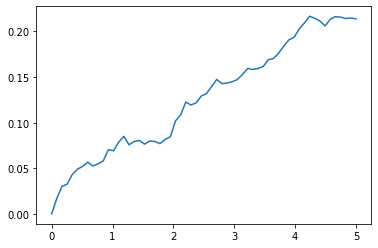

In [9]:
plot(t, exercise_value(X).mean(axis=1));

In [10]:
basis = PolynomialRegressionBasis(3)
print(basis)

x**0 + x**1 + x**2 + x**3


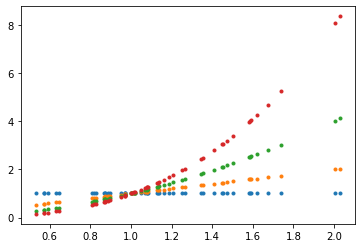

In [11]:
x = X[-1, :]
plot(x, basis(x), '.');

In [12]:
def perform_regression(basis, x, y):
    return lstsq(basis(x), y, rcond=None)[0]

In [13]:
beta = perform_regression(basis, x, exercise_value(x))
beta

array([ 0.97504081, -3.0170201 ,  2.64562475, -0.56527416])

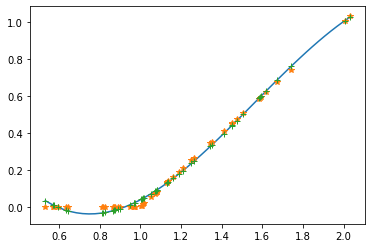

In [14]:
_x = np.linspace(np.min(x), np.max(x))
plot(_x, basis(_x) @ beta);
plot(x, exercise_value(x), '*');
plot(x, basis(x) @ beta, '+');

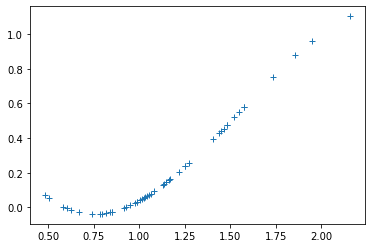

In [15]:
plot(X[-2,:], basis(X[-2, :]) @ beta, '+');

In [21]:
def backward_regression(basis, exercise_value, X):
    beta = perform_regression(basis, X[-1, :], exercise_value(X[-1, :]))
    for i in reversed(range(X.shape[0] - 1)):
        x = X[i, :]
        exercise = exercise_value(x)
        continuation = basis(x) @ beta
        total = np.maximum(exercise, continuation)
        yield total, x, beta, continuation, exercise
        beta = perform_regression(basis, x, total)

In [22]:
bw_regr_steps = list(backward_regression(basis, exercise_value, X))

In [23]:
@interact(n_steps=IntSlider(min=1, max=X.shape[0]-1, value=1))
def step(n_steps):
    total, x, beta, continuation, exercise = bw_regr_steps[n_steps]
    plot(x, continuation, '+');

interactive(children=(IntSlider(value=1, description='n_steps', max=59, min=1), Output()), _dom_classes=('widg…

In [18]:
for total, x, beta, continuation, exercise in backward_regression(basis, exercise_value, X):
    print(beta)

[ 0.97504081 -3.0170201   2.64562475 -0.56527416]
[ 0.92095299 -2.80374088  2.43808167 -0.50529156]
[ 0.91025617 -2.75251799  2.38956693 -0.49149958]
[ 0.86265725 -2.58882043  2.23114376 -0.44454039]
[ 0.84645646 -2.54027173  2.19057539 -0.43359535]
[ 0.8421265  -2.52407476  2.17691605 -0.42994325]
[ 0.83180381 -2.49056545  2.14507723 -0.42010848]
[ 0.81417226 -2.42973473  2.08339024 -0.40053047]
[ 0.81040179 -2.41773525  2.07312654 -0.39746667]
[ 0.8111767  -2.41916058  2.07487573 -0.39800114]
[ 0.79993049 -2.38027748  2.03593716 -0.38591137]
[ 0.77865823 -2.30999421  1.96657429 -0.36455328]
[ 0.77936015 -2.31262389  1.9697871  -0.36544461]
[ 0.78008112 -2.31490222  1.97222808 -0.3660864 ]
[ 0.78060255 -2.31614561  1.97336418 -0.3663734 ]
[ 0.78097026 -2.31675498  1.97371699 -0.36643938]
[ 0.78148064 -2.31776136  1.97442146 -0.36659272]
[ 0.78260658 -2.31994491  1.97587063 -0.36689527]
[ 0.78347274 -2.32205605  1.97760008 -0.36731933]
[ 0.78433886 -2.32393748  1.97895545 -0.36762447]


In [19]:
assert np.average(total) >= np.average(exercise_value(X[-1, :]))

AssertionError: 